## Dataset exploration 

This notebook glimpses into the structure of the MS COCO Captions dataset. Some examples of the images and associated labels and metadata can be seen. Furthermore, the notebook implements the sorting of the images into categories.

WARNING: It only downloads the testing split of the dataset to avoid large downloads. 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import json
from pycocotools.coco import COCO
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio

### Misc useful stuff

tf.data.Dataset.element_spec
Note that when batching a dataset with a variable shape, you need to use Dataset.padded_batch.

In [ ]:
# for line in dataset.take(5):
#   print(line.numpy())


In [15]:
# tfds.__version__
# tfds.list_builders()


['abstract_reasoning',
 'aflw2k3d',
 'amazon_us_reviews',
 'bair_robot_pushing_small',
 'bigearthnet',
 'binarized_mnist',
 'binary_alpha_digits',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_corrupted',
 'clevr',
 'cnn_dailymail',
 'coco',
 'coco2014',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eurosat',
 'fashion_mnist',
 'flores',
 'food101',
 'gap',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'image_label_folder',
 'imagenet2012',
 'imagenet2012_corrupted',
 'imdb_reviews',
 'iris',
 'kitti',
 'kmnist',
 'lfw',
 'lm1b',
 'lsun',
 'mnist',
 'mnist_corrupted',
 'moving_mnist',
 'multi_nli',
 'nsynth',
 'omniglot',

### Explore COCO

In [2]:
# WARNING: large download ahead
# TODO: check if ds exists locally before triggering download

# ds = tfds.load('coco/2014', split='validation', shuffle_files=False, data_dir="../../data/")
# assert isinstance(ds, tf.data.Dataset)
# print(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../../data/coco/2014/1.0.0.incomplete2LAI3Z/coco-train.tfrecord


  0%|          | 0/82783 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../../data/coco/2014/1.0.0.incomplete2LAI3Z/coco-validation.tfrecord


  0%|          | 0/40504 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../../data/coco/2014/1.0.0.incomplete2LAI3Z/coco-test.tfrecord


  0%|          | 0/40775 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../../data/coco/2014/1.0.0.incomplete2LAI3Z/coco-test2015.tfrecord


  0%|          | 0/81434 [00:00<?, ? examples/s]

Computing statistics...:   0%|          | 0/4 [00:00<?, ? split/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


0 examples [00:00, ? examples/s]

ERROR:absl:Statistics generation doesn't work for nested structures yet


0 examples [00:00, ? examples/s]

ERROR:absl:Statistics generation doesn't work for nested structures yet


0 examples [00:00, ? examples/s]

ERROR:absl:Statistics generation doesn't work for nested structures yet


0 examples [00:00, ? examples/s]

ERROR:absl:Statistics generation doesn't work for nested structures yet


Dataset coco downloaded and prepared to ../../data/coco/2014/1.0.0. Subsequent calls will reuse this data.
<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), image/id: (), objects: {area: (None,), bbox: (None, 4), is_crowd: (None,), label: (None,)}}, types: {image: tf.uint8, image/filename: tf.string, image/id: tf.int64, objects: {area: tf.int64, bbox: tf.float32, is_crowd: tf.bool, label: tf.int64}}>


In [7]:
example = ds.take(1)
for ex in example: 
  print(list(ex.keys()))
  image = ex["image"]
  label = ex["objects"]["label"]
  print(image.shape, label)


['image', 'image/filename', 'image/id', 'objects']
(640, 640, 3) tf.Tensor([ 0 77 57], shape=(3,), dtype=int64)


In [5]:
example

<TakeDataset shapes: {image: (None, None, 3), image/filename: (), image/id: (), objects: {area: (None,), bbox: (None, 4), is_crowd: (None,), label: (None,)}}, types: {image: tf.uint8, image/filename: tf.string, image/id: tf.int64, objects: {area: tf.int64, bbox: tf.float32, is_crowd: tf.bool, label: tf.int64}}>

In [4]:
# load downloaded file
ds, metainfo = tfds.load('coco/2014', split='validation', shuffle_files=False, download=False, data_dir="../../data/", with_info=True)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


In [5]:
print(metainfo)

tfds.core.DatasetInfo(
    name='coco',
    version=1.0.0,
    description='COCO is a large-scale object detection, segmentation, and
captioning dataset. This version contains images, bounding boxes "
and labels for the 2014 version.
Note:
 * Some images from the train and validation sets don't have annotations.
 * Coco 2014 and 2017 uses the same images, but different train/val/test splits
 * The test split don't have any annotations (only images).
 * Coco defines 91 classes but the data only uses 80 classes.
 * Panotptic annotations defines defines 200 classes but only uses 133.
',
    urls=['http://cocodataset.org/#home'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'image/id': Tensor(shape=(), dtype=tf.int64),
        'objects': Sequence({
            'area': Tensor(shape=(), dtype=tf.int64),
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'is

In [10]:
# json containing actual captions
with open("../../data/downloads/extracted/ZIP.images.cocodat.org_annotat_annotat_trainvaAxKWu8gMRaHR92v5qQ6tJ-lOmexikghElQekkXo78Ak.zip/annotations/captions_val2014.json") as f:
    annotations = json.load(f)

In [11]:
annotations.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [12]:
len(annotations['annotations'])

202654

In [13]:
len(annotations['images']) # nr of val images in the coco/2014 config

40504

In [16]:
annotations["annotations"][0]

{'image_id': 203564,
 'id': 37,
 'caption': 'A bicycle replica with a clock as the front wheel.'}

In [17]:
# json containing segmentation, bb, category ID info
with open("../../data/downloads/extracted/ZIP.images.cocodat.org_annotat_annotat_trainvaAxKWu8gMRaHR92v5qQ6tJ-lOmexikghElQekkXo78Ak.zip/annotations/instances_val2014.json") as f:
    ds_info = json.load(f)

In [18]:
ds_info.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [21]:
len(ds_info['categories'])
ds_info['categories'][0]
ds_info['annotations'][0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

### Plan

1. Install and get familiar with pycocotools: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
2. Plot a couple of examples of a record
3. Figure out a way to filter by category
4. Figure out a way to transform this into a tfds instance
5. Prepare corresponding scripts

#### Example from pycocotools tutorial https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [8]:
# load annotation file
coco = COCO("../../data/downloads/extracted/ZIP.images.cocodat.org_annotat_annotat_trainvaAxKWu8gMRaHR92v5qQ6tJ-lOmexikghElQekkXo78Ak.zip/annotations/instances_val2014.json")

# display categories (80, used for object detection or segmentation) and supercategories (12)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


loading annotations into memory...
Done (t=3.57s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
indoor appliance sports furniture animal outdoor electronic vehicle food kitchen person accessory


In [9]:
len(nms)

12

In [19]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard']); # ,'skateboard', ,'dog'
imgIds = coco.getImgIds(catIds=catIds );
print(len(catIds), " ", catIds)
print(len(imgIds), " ", imgIds)

3   [1, 18, 41]
19   [438915, 209028, 500100, 372874, 282768, 360595, 366484, 449560, 28842, 241837, 324158, 231240, 493020, 547421, 549220, 255209, 353644, 279278, 45175]


In [31]:
imgIds = coco.getImgIds(imgIds = [45175])
print(imgIds)
img = coco.loadImgs(imgIds)[0]
img

[45175]


{'license': 4,
 'file_name': 'COCO_val2014_000000045175.jpg',
 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000045175.jpg',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-18 10:55:19',
 'flickr_url': 'http://farm3.staticflickr.com/2188/2273154848_bbd217868d_z.jpg',
 'id': 45175}

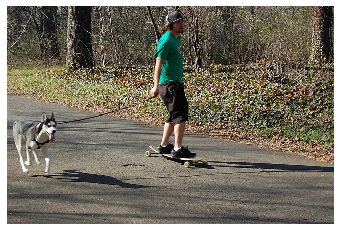

In [32]:
# load and display example image
I = iio.imread('../../data/downloads/extracted/ZIP.images.cocodataset.org_zips_val2014_pvoFgUgScNHF-B32eNKpggUpVZ5-ATNBD48vuO5_eA.zip/val2014/%s'%(img['file_name']))
# use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
[222259, 242536, 255565, 255925, 257224]
[{'image_id': 45175, 'id': 222259, 'caption': 'a man riding a skateboard with his dog.'}, {'image_id': 45175, 'id': 242536, 'caption': 'A man on a skateboard walks a dog on a leash.'}, {'image_id': 45175, 'id': 255565, 'caption': 'A boy on a skateboard walking a dog on a pavement.'}, {'image_id': 45175, 'id': 255925, 'caption': 'A man skateboarding while walking his dog. '}, {'image_id': 45175, 'id': 257224, 'caption': 'A man walking his dog while riding a skateboard'}]
a man riding a skateboard with his dog.
A man on a skateboard walks a dog on a leash.
A boy on a skateboard walking a dog on a pavement.
A man skateboarding while walking his dog. 
A man walking his dog while riding a skateboard


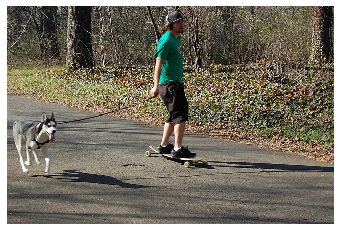

In [35]:
# initialize COCO api for caption annotations
coco_caps=COCO("../../data/downloads/extracted/ZIP.images.cocodat.org_annotat_annotat_trainvaAxKWu8gMRaHR92v5qQ6tJ-lOmexikghElQekkXo78Ak.zip/annotations/captions_val2014.json")

# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
print(annIds)
anns = coco_caps.loadAnns(annIds)
print(anns)

coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()


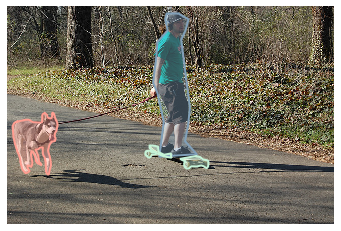

In [36]:
# load and display instance annotations (as in objects)
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

#### Try loading entire dataset

In [39]:
# convenience functions making loading the ds easier are implemented as separate module: 
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/coco.py

Options for dealing with the dataset:
* use an analogous util script with standard records lists / dicts
* use keras utility functions for loading data: https://www.tensorflow.org/tutorials/text/image_captioning?hl=nl
* use a util script returning tfds instance
    * how do I construct data points form separate image and annotation files?

Crucial decision criterion: what is the most suitable format for feeding the data it into the keras.ResNet50 pretrained model and tf.keras.layers.LSTM layer? 
    * yes, just use straight up tfds format in cifar10 tf example
    * https://keras.io/examples/vision/image_captioning/

In [ ]:
# batching

### Convenience scripts for loading and preparing dataset
From keras tutorial: https://keras.io/examples/vision/image_captioning/
and tensorflow tutorial: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb, https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/coco.py

In [11]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.applications import efficientnet
#from tensorflow.keras.layers import TextVectorization

seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

# from .. import utils #as download
# from . import utils
import download

Download dataset from cocodataset.org:
* use convenience functions in utils.download
* put in data directories, both images and annotations
* create tfds with convenience function

In [ ]:
base_url = "https://cocodataset.org"
filenames = ["zips/val2014.zip",
                 "annotations/annotations_trainval2014.zip"]
# download
for filename in filenames:
    download.maybe_download_an_extract(
        base_url=base_url,
        filename=filename,
        download_dir="../../data/")
    

In [ ]:
# find out max caption length
# decide on vocab size